# Animated Scatterplot 

similar to the one by Hans Rosling (see [his Box-by-Box talk](https://www.youtube.com/watch?v=fTznEIZRkLg))

In [1]:
# all imports in one place and on top
import pandas as pd
from matplotlib import pyplot as plt,colors
import seaborn as sns
import imageio

In [2]:
# create output path (uses a bash command)
!mkdir -p frames

In [3]:
PATH = 'frames'

In [17]:
# read data
fert = pd.read_csv('gapminder_total_fertility.csv', index_col=0)
life = pd.read_excel('gapminder_lifeexpectancy.xlsx', index_col=0)
pop = pd.read_excel('gapminder_population.xlsx', index_col=0)
cont = pd.read_csv('continents.csv', sep=';')

In [18]:
pop.head(5)

,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Total population,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,3280000.0,3280000.0,3323519.0,3448982.0,3625022.0,3810047.0,3973968.0,4169690.0,4419695.0,4710171.0,...,25183615.0,25877544.0,26528741.0,27207291.0,27962207.0,28809167.0,29726803.0,30682500.0,31627506.0,32526562.0
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15700.0,15700.0,15700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,410445.0,423591.0,438671.0,457234.0,478227.0,506889.0,552800.0,610036.0,672544.0,741688.0,...,3050741.0,3010849.0,2968026.0,2929886.0,2901883.0,2886010.0,2880667.0,2883281.0,2889676.0,2896679.0
Algeria,2503218.0,2595056.0,2713079.0,2880355.0,3082721.0,3299305.0,3536468.0,3811028.0,4143163.0,4525691.0,...,33749328.0,34261971.0,34811059.0,35401790.0,36036159.0,36717132.0,37439427.0,38186135.0,38934334.0,39666519.0


In [19]:
# inspect shapes
fert.shape, life.shape, pop.shape, cont.shape

((260, 216), (260, 217), (275, 81), (194, 2))

In [20]:
# convert column labels to integers
fert.columns = fert.columns.astype(int)

In [21]:
# change index labels
fert.index.name = 'country'
pop.index.name = 'country'
life.index.name = 'country'

### Simple Statistics

In [22]:
pop[2010].sum()  # sum over all countries (data not 100% clean!)

6929767495.0

Text(0, 0.5, 'population[millions]')

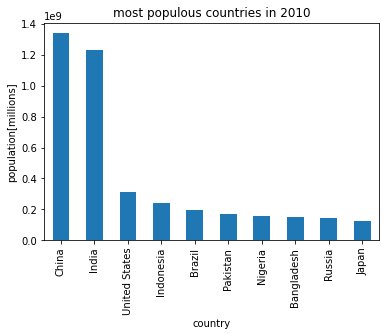

In [23]:
top10 = pop[2010].sort_values(ascending=False).head(10)
top10mil = top10 // 1_000_000
top10.plot.bar()
plt.title('most populous countries in 2010')
plt.ylabel('population[millions]')

Text(0.5, 1.0, 'population of Romania')

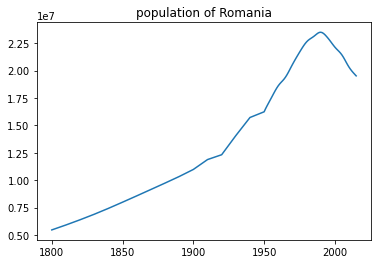

In [24]:
pop.loc['Romania'].plot()
plt.title('population of Romania')

Text(0.5, 1.0, 'distribution of children per woman in 2010')

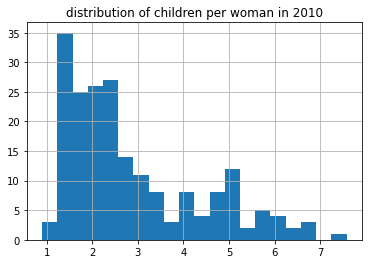

In [25]:
fert[2010].hist(bins=20)
plt.title('distribution of children per woman in 2010')

### Convert to long format

In [26]:
fert_long = fert.reset_index()
fert_long = fert_long.melt(id_vars='country', var_name='year', value_name='fertility_rate')
fert_long.head(3) # check how it looks like

,country,year,fertility_rate
0,Abkhazia,1800,NaN
1,Afghanistan,1800,7.0
2,Akrotiri and Dhekelia,1800,NaN


In [27]:
pop_long = pop.reset_index()
pop_long = pop_long.melt(id_vars='country', var_name='year', value_name='population')

In [28]:
life_long = life.reset_index()
life_long = life_long.melt(id_vars='country', var_name='year', value_name='life_exp')

### Merge

In [29]:
# merge on two columns
df = pd.merge(fert_long, pop_long, on=['country', 'year'])
df = pd.merge(df, life_long, on=['country', 'year'])
df = pd.merge(df, cont, on='country', how='outer')
df.iloc[100:105]  # manually found spot without NaNs

,country,year,fertility_rate,population,life_exp,continent
100,Afghanistan,1954,7.67,8150037.0,28.73,Asia
101,Afghanistan,1955,7.67,8270024.0,29.27,Asia
102,Afghanistan,1956,7.67,8398309.0,29.80,Asia
103,Afghanistan,1957,7.67,8534913.0,30.34,Asia
104,Afghanistan,1958,7.67,8679848.0,30.86,Asia


In [30]:
 df.shape # all countries x years

(20998, 6)

In [31]:
# remove empty values - we only want complete data
df.dropna(inplace=True)

### Plotting

<AxesSubplot:xlabel='life_exp', ylabel='fertility_rate'>

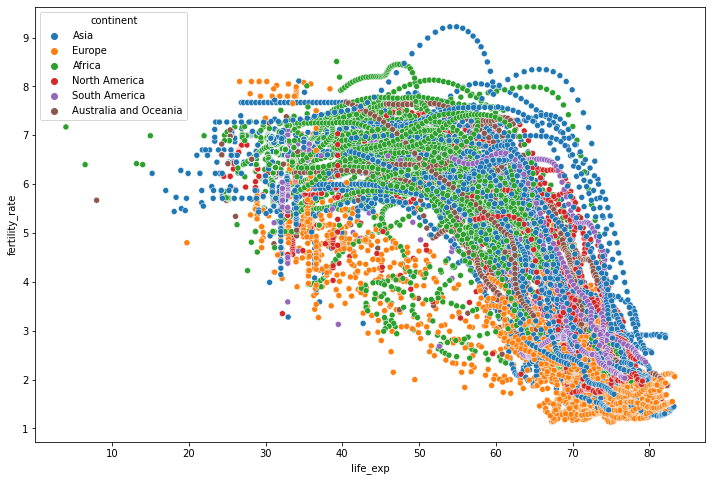

In [32]:
# big image with all data as a teaser
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='life_exp', y='fertility_rate', hue='continent')

In [33]:
# scale to range [0,1]
df['population_scaled'] = (df['population'] - df['population'].min())/(df['population'].max()-df['population'].min())
# scale to range [1, 10000]
df['population_scaled'] = (10000-1)*df['population_scaled']+1

In [34]:
# create frames
# written iteratively
for year in range(1950, 2016): # add ,10 for bigger steps -> faster when debugging
    print(year, end=', ')  # debug info: if there is
    subdf = df.loc[df['year'] == year]
   
    plt.figure(figsize=(12, 8)) # <-- reset figure, crashes without this line
    sns.scatterplot(x='life_exp', y='fertility_rate', hue='continent', 
                    size='population', 
                    # for correct global scaling across all years
                    sizes=(subdf['population_scaled'].min(), subdf['population_scaled'].max()), 
                    legend=False, alpha=0.8, data=subdf)
    plt.axis([0, 85, 0, 9.5])
    plt.title(f"{year}", loc='left')
    plt.xlabel('life expectancy [years]')
    plt.ylabel('fertility [children per women]')
    sns.despine()
    plt.savefig(f'{PATH}/frame_{year}.png', dpi=90)
    plt.close() # do not display plot in output

1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 

In [35]:
images = []

for year in range(1950, 2016):
    filename = f'{PATH}/frame_{year}.png'
    images.append(imageio.imread(filename))

imageio.mimsave('animated_plot.gif', images, fps=10)

![](animated_plot.gif)